Manifold Learning

We have seen how principal component analysis (PCA) can be used in the dimensionality reduction task—reducing the number of features of a dataset while maintaining the essential relationships between the points.

Here we will demonstrate a number of manifold methods, going most deeply into a couple techniques: multidimensional scaling (MDS), locally linear embedding (LLE), and isometric mapping (IsoMap).

We begin with the standard imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Manifold Learning: "HELLO"

To make these concepts more clear, let's start by generating some two-dimensional data that we can use to define a manifold.
Here is a function that will create data in the shape of the word "HELLO":

In [2]:
def make_hello(N=1000, rseed=42):
    # Make a plot with "HELLO" text; save as PNG
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
    fig.savefig('hello.png')
    plt.close(fig)
    
    # Open this PNG and draw random points from it
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

Let's call the function and visualize the resulting data:

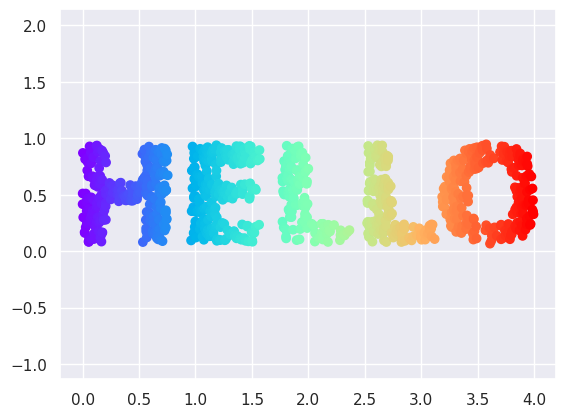

In [27]:
import matplotlib as mpl
X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=mpl.colormaps['rainbow'])
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

The output is two dimensional, and consists of points drawn in the shape of the word, "HELLO".
This data form will help us to see visually what these algorithms are doing.

## Multidimensional Scaling (MDS)

Looking at data like this, we can see that the particular choice of *x* and *y* values of the dataset are not the most fundamental description of the data: we can scale, shrink, or rotate the data, and the "HELLO" will still be apparent.
For example, if we use a rotation matrix to rotate the data, the *x* and *y* values change, but the data is still fundamentally the same:

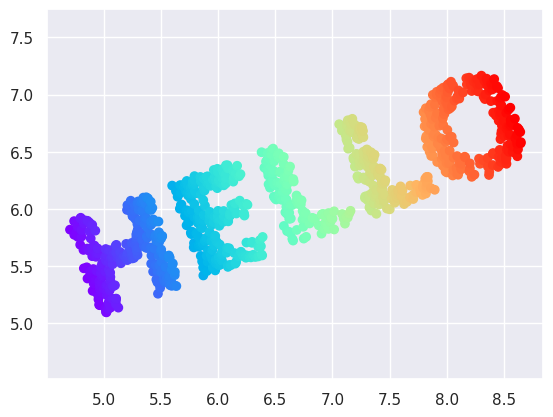

In [28]:
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)
    
X2 = rotate(X, 20) + 5
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal');

This tells us that the *x* and *y* values are not necessarily fundamental to the relationships in the data.
Let's use Scikit-Learn's efficient ``pairwise_distances`` function to do this for our original data:

In [29]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
D.shape

(1000, 1000)

As promised, for our *N*=1,000 points, we obtain a 1000×1000 matrix, which can be visualized as shown here:

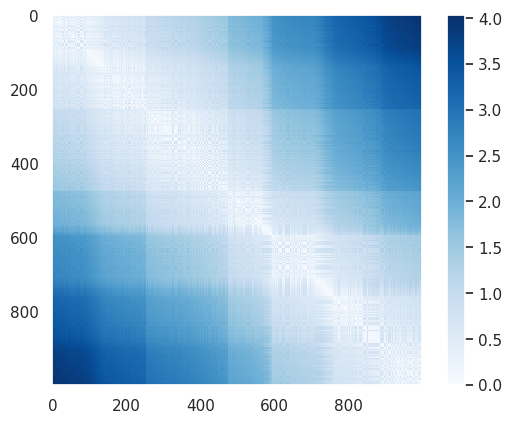

In [30]:
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

If we similarly construct a distance matrix for our rotated and translated data, we see that it is the same:

In [31]:
D2 = pairwise_distances(X2)
np.allclose(D, D2)

True

This distance matrix gives us a representation of our data that is invariant to rotations and translations, but the visualization of the matrix above is not entirely intuitive.

Let's see how it works for our distance matrix, using the ``precomputed`` dissimilarity to specify that we are passing a distance matrix:

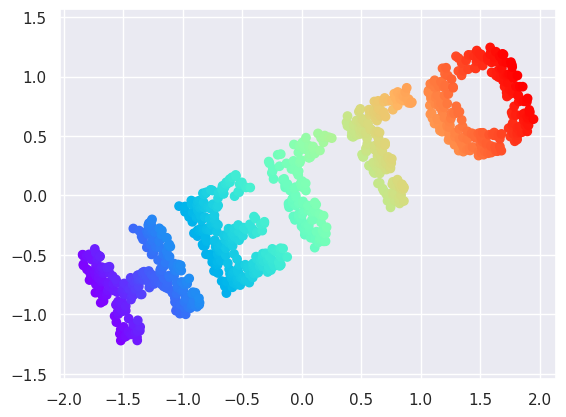

In [32]:
from sklearn.manifold import MDS
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1, normalized_stress='auto')
out = model.fit_transform(D)
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal');

The MDS algorithm recovers one of the possible two-dimensional coordinate representations of our data, using *only* the $N\times N$ distance matrix describing the relationship between the data points.

## MDS as Manifold Learning

The usefulness of this becomes more apparent when we consider the fact that distance matrices can be computed from data in *any* dimension.

In [33]:
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])
    
X3 = random_projection(X, 3)
X3.shape

(1000, 3)

Let's visualize these points to see what we're working with:

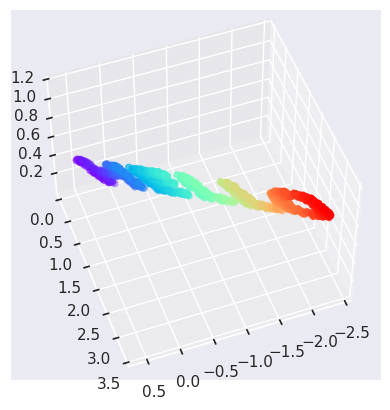

In [34]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2],
             **colorize)
ax.view_init(azim=70, elev=50)

We can now ask the ``MDS`` estimator to input this three-dimensional data, compute the distance matrix, and then determine the optimal two-dimensional embedding for this distance matrix.
The result recovers a representation of the original data:

In [ ]:
model = MDS(n_components=2, random_state=1, normalized_stress='auto')
out3 = model.fit_transform(X3)
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal');

In the case of MDS, the quantity preserved is the distance between every pair of points.

## Nonlinear Embeddings: Where MDS Fails

Our discussion thus far has considered *linear* embeddings, which essentially consist of rotations, translations, and scalings of data into higher-dimensional spaces.

Consider the following embedding, which takes the input and contorts it into an "S" shape in three dimensions:

In [ ]:
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_hello_s_curve(X)

This is again three-dimensional data, but we can see that the embedding is much more complicated:

In [ ]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2],
             **colorize);

The fundamental relationships between the data points are still there, but this time the data has been transformed in a nonlinear way: it has been wrapped-up into the shape of an "S."

If we try a simple MDS algorithm on this data, it is not able to "unwrap" this nonlinear embedding, and we lose track of the fundamental relationships in the embedded manifold:

In [ ]:
from sklearn.manifold import MDS
model = MDS(n_components=2, random_state=2, normalized_stress='auto')
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal');

The best two-dimensional *linear* embeding does not unwrap the S-curve, but instead throws out the original y-axis.

## Nonlinear Manifolds: Locally Linear Embedding

How can we move forward here? Stepping back, we can see that the source of the problem is that MDS tries to preserve distances between faraway points when constructing the embedding.

LLE comes in a number of flavors; here we will use the *modified LLE* algorithm to recover the embedded two-dimensional manifold.
In general, modified LLE does better than other flavors of the algorithm at recovering well-defined manifolds with very little distortion:

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding
model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified',
                               eigen_solver='dense')
out = model.fit_transform(XS)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15);

The result remains somewhat distorted compared to our original manifold, but captures the essential relationships in the data!

## Example: Isomap on Faces

One place manifold learning is often used is in understanding the relationship between high-dimensional data points.

Running this command will download the data and cache it in your home directory for later use:

In [ ]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
faces.data.shape

We have 2,370 images, each with 2,914 pixels.
In other words, the images can be thought of as data points in a 2,914-dimensional space!

Let's quickly visualize several of these images to see what we're working with:

In [ ]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

We would like to plot a low-dimensional embedding of the 2,914-dimensional data to learn the fundamental relationships between the images.

In [ ]:
from sklearn.decomposition import PCA
model = PCA(100).fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance');

We see that for this data, nearly 100 components are required to preserve 90% of the variance: this tells us that the data is intrinsically very high dimensional—it can't be described linearly with just a few components.

We can compute an Isomap embedding on these faces using the same pattern shown before:

In [ ]:
from sklearn.manifold import Isomap
model = Isomap(n_components=2)
proj = model.fit_transform(faces.data)
proj.shape

The output is a two-dimensional projection of all the input images.
To get a better idea of what the projection tells us, let's define a function that will output image thumbnails at the locations of the projections:

In [ ]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

Calling this function now, we see the result:

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2),
                images=faces.images[:, ::2, ::2])

The result is interesting: the first two Isomap dimensions seem to describe global image features: the overall darkness or lightness of the image from left to right, and the general orientation of the face from bottom to top.